# Longitudinal QuasiCopula GWAS with Mixed Marginals

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [48]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots
using ProgressMeter

BLAS.set_num_threads(1)
Threads.nthreads()

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end


_make_snparray (generic function with 1 method)

## Simulate data

In [57]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
    βtrue = rand(Uniform(-0.2, 0.2), p)
    dist = y_distribution()
    link = canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.1, m)
    V1 = ones(d, d)
    V2 = Matrix(I, d, d)
    Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2

    # simulate design matrices
    Random.seed!(seed)
    X_full = [hcat(ones(d), randn(d, p - 1)) for i in 1:n]

    # simulate random SnpArray with 100 SNPs and randomly choose k SNPs to be causal
    Random.seed!(2022)
    G = simulate_random_snparray(undef, n, q)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    γtrue = zeros(q)
    γtrue[1:k] .= rand([-0.2, 0.2], k)
    shuffle!(γtrue)
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 10.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    else
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{DiscreteUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, Γ, G, βtrue, θtrue, γtrue
end

k = 0 # number of causal SNPs

qc_model, Γ, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 5000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2022,
    y_distribution = Normal,
    T = Float64,
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Normal
  * link function: IdentityLink
  * number of clusters: 5000
  * cluster size min, max: 5, 5
  * number of variance components: 1
  * number of fixed effects: 3



## Poisson likelihood ratio test

In [51]:
function likelihood_ratio_test(qc_model::Union{GLMCopulaVCModel, NBCopulaVCModel}, G::SnpArray)
    n, p = size(G)
    #
    # Fit null model
    #
    @time optm = QuasiCopula.fit!(qc_model,
        Ipopt.IpoptSolver(
            print_level = 0, 
            tol = 10^-6, 
            max_iter = 1000,
            accept_after_max_steps = 4,
            warm_start_init_point="yes", 
            limited_memory_max_history = 6, # default value
            hessian_approximation = "limited-memory",
        ));
    H0_logl = loglikelihood!(qc_model, false, false)
    #
    # Fit alt models
    #
    d = size(qc_model.data[1].X, 1)
    obs_alt = Vector{eltype(qc_model.data)}(undef, n)
    pvals = zeros(p)
    @showprogress for j in 1:p
        empty!(obs_alt)
        for (i, gc) in enumerate(qc_model.data)
            snp = [convert(Float64, G[i, j]) for _ in 1:d]
            push!(obs_alt, GLMCopulaVCObs(gc.y, [gc.X snp], gc.V, Poisson(), LogLink()))
        end
        qc_model_alt = GLMCopulaVCModel(obs_alt)
        QuasiCopula.fit!(qc_model_alt,
            Ipopt.IpoptSolver(
                print_level = 0, 
                tol = 10^-6, 
                max_iter = 1000,
                accept_after_max_steps = 4,
                warm_start_init_point="yes", 
                limited_memory_max_history = 6, # default value
                hessian_approximation = "limited-memory",
            ))
        ts = -2 * (H0_logl - loglikelihood!(qc_model_alt, false, false))
        pvals[j] = ccdf(Chisq(1), ts)
    end
    return pvals
end
pvals = likelihood_ratio_test(qc_model, G)

  0.350770 seconds (1.10 M allocations: 20.356 MiB, 4.77% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:05:46


1000-element Vector{Float64}:
 0.49321619292430774
 0.3023829329383551
 0.9002604016679233
 0.37483659822373544
 0.8328691061310007
 0.622597641170532
 0.15599637764643667
 0.7220570867061658
 0.09532183608636428
 0.9728847243538723
 0.8262990350507694
 0.24630472412148266
 0.7063912630574284
 ⋮
 0.8392120689815238
 0.6126589288392644
 0.5233336944926922
 0.9872212640345841
 0.3222781580567028
 0.9757399999431181
 0.10560532782850664
 0.7412217289983204
 0.7975741372137227
 0.09669584984826626
 0.2947647024561551
 0.36046360484435724

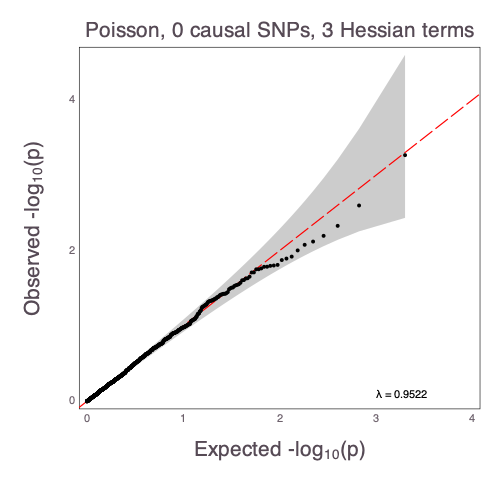

In [53]:
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

## Bernoulli likelihood ratio test

In [55]:
function likelihood_ratio_test(qc_model::Union{GLMCopulaVCModel, NBCopulaVCModel}, G::SnpArray)
    n, p = size(G)
    #
    # Fit null model
    #
    @time optm = QuasiCopula.fit!(qc_model,
        Ipopt.IpoptSolver(
            print_level = 0, 
            tol = 10^-6, 
            max_iter = 1000,
            accept_after_max_steps = 4,
            warm_start_init_point="yes", 
            limited_memory_max_history = 6, # default value
            hessian_approximation = "limited-memory",
        ));
    H0_logl = loglikelihood!(qc_model, false, false)
    #
    # Fit alt models
    #
    d = size(qc_model.data[1].X, 1)
    obs_alt = Vector{eltype(qc_model.data)}(undef, n)
    pvals = zeros(p)
    @showprogress for j in 1:p
        empty!(obs_alt)
        for (i, gc) in enumerate(qc_model.data)
            snp = [convert(Float64, G[i, j]) for _ in 1:d]
            push!(obs_alt, GLMCopulaVCObs(gc.y, [gc.X snp], gc.V, Bernoulli(), LogitLink()))
        end
        qc_model_alt = GLMCopulaVCModel(obs_alt)
        QuasiCopula.fit!(qc_model_alt,
            Ipopt.IpoptSolver(
                print_level = 0, 
                tol = 10^-6, 
                max_iter = 1000,
                accept_after_max_steps = 4,
                warm_start_init_point="yes", 
                limited_memory_max_history = 6, # default value
                hessian_approximation = "limited-memory",
            ))
        ts = -2 * (H0_logl - loglikelihood!(qc_model_alt, false, false))
        pvals[j] = ccdf(Chisq(1), ts)
    end
    return pvals
end
pvals = likelihood_ratio_test(qc_model, G)

  1.628795 seconds (3.85 M allocations: 169.796 MiB, 2.10% gc time, 83.37% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:05:36


1000-element Vector{Float64}:
 0.3476048965038256
 0.8231499499756256
 0.6993385670661735
 0.33646580699633044
 0.2734073726630978
 0.41914634604373824
 0.006001244861711848
 0.8628276206657192
 0.5013758598066755
 0.03026262276253031
 0.6736667591082424
 0.24805529193722822
 0.14603204805907707
 ⋮
 0.7058484520137138
 0.06997390205493387
 0.12978824332494368
 0.7624419841070371
 0.09767734563617966
 0.907829967872618
 0.22133448651438603
 0.21260674493138104
 0.5914656829310413
 0.9709398707907984
 0.33508824033912193
 0.0425563490860776

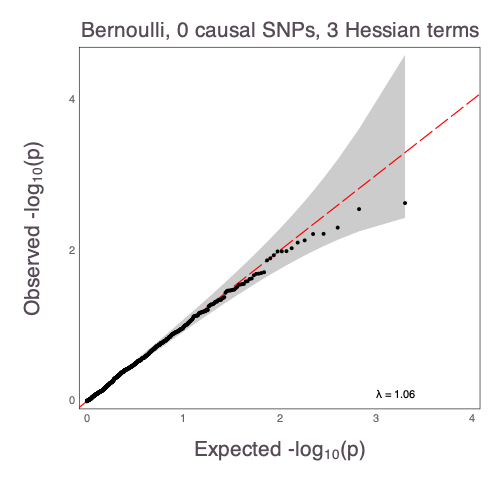

In [56]:
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

## Normal likelihood ratio test

In [61]:
function likelihood_ratio_test(qc_model::GaussianCopulaVCModel, G::SnpArray)
    n, p = size(G)
    #
    # Fit null model
    #
    @time optm = QuasiCopula.fit!(qc_model,
        Ipopt.IpoptSolver(
            print_level = 0, 
            tol = 10^-6, 
            max_iter = 1000,
            accept_after_max_steps = 4,
            warm_start_init_point="yes", 
            limited_memory_max_history = 6, # default value
            hessian_approximation = "limited-memory",
        ));
    H0_logl = loglikelihood!(qc_model, false, false)
    #
    # Fit alt models
    #
    d = size(qc_model.data[1].X, 1)
    obs_alt = Vector{eltype(qc_model.data)}(undef, n)
    pvals = zeros(p)
    @showprogress for j in 1:p
        empty!(obs_alt)
        for (i, gc) in enumerate(qc_model.data)
            snp = [convert(Float64, G[i, j]) for _ in 1:d]
            push!(obs_alt, GaussianCopulaVCObs(gc.y, [gc.X snp], gc.V))
        end
        qc_model_alt = GaussianCopulaVCModel(obs_alt)
        QuasiCopula.fit!(qc_model_alt,
            Ipopt.IpoptSolver(
                print_level = 0, 
                tol = 10^-6, 
                max_iter = 1000,
                accept_after_max_steps = 4,
                warm_start_init_point="yes", 
                limited_memory_max_history = 6, # default value
                hessian_approximation = "limited-memory",
            ))
        ts = -2 * (H0_logl - loglikelihood!(qc_model_alt, false, false))
        pvals[j] = ccdf(Chisq(1), ts)
    end
    return pvals
end
pvals = likelihood_ratio_test(qc_model, G)

  1.077294 seconds (8.25 M allocations: 220.404 MiB)


Progress:   1%|▍                                        |  ETA: 1:04:23┌ Warning: Optimization unsuccesful; got UserLimit
└ @ QuasiCopula /Users/biona001/.julia/dev/QuasiCopula/src/parameter_estimation/fit_gaussian_vc.jl:36
Progress:   1%|▋                                        |  ETA: 1:42:30┌ Warning: Optimization unsuccesful; got UserLimit
└ @ QuasiCopula /Users/biona001/.julia/dev/QuasiCopula/src/parameter_estimation/fit_gaussian_vc.jl:36
Progress:   2%|▊                                        |  ETA: 2:02:28┌ Warning: Optimization unsuccesful; got UserLimit
└ @ QuasiCopula /Users/biona001/.julia/dev/QuasiCopula/src/parameter_estimation/fit_gaussian_vc.jl:36
Progress:   3%|█▎                                       |  ETA: 2:06:36┌ Warning: Optimization unsuccesful; got UserLimit
└ @ QuasiCopula /Users/biona001/.julia/dev/QuasiCopula/src/parameter_estimation/fit_gaussian_vc.jl:36
Progress:   3%|█▎                                       |  ETA: 2:12:48┌ Warning: Optimization unsuccesf

LoadError: TaskFailedException

[91m    nested task error: [39mDomainError with -1.086855456321266:
    log will only return a complex result if called with a complex argument. Try log(Complex(x)).
    Stacktrace:
     [1] [0m[1mthrow_complex_domainerror[22m[0m[1m([22m[90mf[39m::[0mSymbol, [90mx[39m::[0mFloat64[0m[1m)[22m
    [90m   @ [39m[90mBase.Math[39m [90m./[39m[90m[4mmath.jl:33[24m[39m
     [2] [0m[1m_log[22m[0m[1m([22m[90mx[39m::[0mFloat64, [90mbase[39m::[0mVal[90m{:ℯ}[39m, [90mfunc[39m::[0mSymbol[0m[1m)[22m
    [90m   @ [39m[90mBase.Math[39m [90m./special/[39m[90m[4mlog.jl:304[24m[39m
     [3] [0m[1mlog[22m
    [90m   @ [39m[90m./special/[39m[90m[4mlog.jl:269[24m[39m[90m [inlined][39m
     [4] [0m[1mloglikelihood![22m[0m[1m([22m[90mgc[39m::[0mGaussianCopulaVCObs[90m{Float64}[39m, [90mβ[39m::[0mVector[90m{Float64}[39m, [90mτ[39m::[0mFloat64, [90mθ[39m::[0mVector[90m{Float64}[39m, [90mneedgrad[39m::[0mBool, [90mneedhess[39m::[0mBool; [90mpenalized[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mQuasiCopula[39m [90m~/.julia/dev/QuasiCopula/src/parameter_estimation/[39m[90m[4mgaussian_VC.jl:189[24m[39m
     [5] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m~/.julia/dev/QuasiCopula/src/parameter_estimation/[39m[90m[4mgaussian_VC.jl:241[24m[39m[90m [inlined][39m
     [6] [0m[1m(::QuasiCopula.var"#134#threadsfor_fun#22"{GaussianCopulaVCModel{Float64}, Bool, Bool, Base.OneTo{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mQuasiCopula[39m [90m./[39m[90m[4mthreadingconstructs.jl:85[24m[39m
     [7] [0m[1m(::QuasiCopula.var"#134#threadsfor_fun#22"{GaussianCopulaVCModel{Float64}, Bool, Bool, Base.OneTo{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[35mQuasiCopula[39m [90m./[39m[90m[4mthreadingconstructs.jl:52[24m[39m

In [ ]:
qq(pvals, dpi=100, titles="Gaussian, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))